In [35]:
import pandas as pd
import requests


def get_fund_k_history(fund_code: str, pz: int = 10000) -> pd.DataFrame:
    '''
    根据基金代码和要获取的页码抓取基金净值信息

    Parameters
    ----------
    fund_code : 6位基金代码
    page : 页码 1 为最新页数据

    Return
    ------
    DataFrame : 包含基金历史k线数据
    '''
    # 请求头
    EastmoneyFundHeaders = {
        'User-Agent': 'EMProjJijin/6.2.8 (iPhone; iOS 13.6; Scale/2.00)',
        'GTOKEN': '98B423068C1F4DEF9842F82ADF08C5db',
        'clientInfo': 'ttjj-iPhone10,1-iOS-iOS13.6',
        'Content-Type': 'application/x-www-form-urlencoded',
        'Host': 'fundmobapi.eastmoney.com',
        'Referer': 'https://mpservice.com/516939c37bdb4ba2b1138c50cf69a2e1/release/pages/FundHistoryNetWorth',
    }
    # 请求参数
    data = {
        'FCODE': f'{fund_code}',
        'appType': 'ttjj',
        'cToken': '1',
        'deviceid': '1',
        'pageIndex': '1',
        'pageSize': f'{pz}',
        'plat': 'Iphone',
        'product': 'EFund',
        'serverVersion': '6.2.8',
        'version': '6.2.8'
    }
    url = 'https://fundmobapi.eastmoney.com/FundMNewApi/FundMNHisNetList'
    json_response = requests.get(
        url, headers=EastmoneyFundHeaders, data=data).json()
    rows = []
    columns = ['date', 'NAV', 'NAV-Cum', 'change']
    if json_response is None:
        return pd.DataFrame(rows, columns=columns)
    datas = json_response['Datas']
    if len(datas) == 0:
        return pd.DataFrame(rows, columns=columns)
    rows = []
    for stock in datas:
        date = stock['FSRQ']
        rows.append({
            'date': date,
            'NAV': stock['DWJZ'],
            'NAV-Cum': stock['LJJZ'],
            'change': stock['JZZZL']
        })

    df = pd.DataFrame(rows)
    df['NAV'] = pd.to_numeric(df['NAV'], errors='coerce')

    df['NAV-Cum'] = pd.to_numeric(df['NAV-Cum'], errors='coerce')

    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    return df


In [44]:

fund_codes = {
    '005658': "hushen 300", 
    '002903': "zhongzheng 500", 
    '001592': "chuangyeban", 
    '002984': "huanbao", 
    '017513': "beizheng 50",
    '008888': "bandaoti - guozheng", 
    '007301': "bandaoti - zhongzheng", 
    '002974': "quanzhixinxi", 
    '015877': "xiaofeidianzi", 
    '012323': "yiliao", 
    '002978': "quanzhiyiyao", 
    '011041': "shengwuyiyao", 
    '008552': "yiyaoweisheng", 
    '014425': "hengshengyiliao", 
    '012348': "hengshengkeji", 
    '006327': "kweb", 
    '004753': "chuanmei", 
    '016129': "honglidibo100", 
    '012857': "zhuyaoxiaofei", 
    '009052': "hongli", 
    '019359': "500dibo", 
    '501050': "shangzheng50AH", 
}

# 遍历基金代码列表获取数据
l_dfs = []
for fund_code in fund_codes:
    # 调用函数获取基金历史净值数据
    fund_data = get_fund_k_history(fund_code)
    fund_data['code'] = fund_code
    fund_data['name'] = fund_codes[fund_code]
    l_dfs.append(fund_data)


df_fund = pd.concat(l_dfs)
df_fund.head()

,date,NAV,NAV-Cum,change,code,name
0,2024-02-23,1.2387,1.2387,0.09,005658,hushen 300
1,2024-02-22,1.2376,1.2376,0.8,005658,hushen 300
2,2024-02-21,1.2278,1.2278,1.3,005658,hushen 300
3,2024-02-20,1.2121,1.2121,0.2,005658,hushen 300
4,2024-02-19,1.2097,1.2097,1.07,005658,hushen 300


In [52]:
print(df_fund.date.min())
df_fund.shape

2015-07-08 00:00:00


(23663, 6)

In [46]:
df_fund_sub = df_fund[df_fund['date']>='2024-02-05']
print(df_fund_sub.shape)
df_fund_sub.head()

(197, 6)


,date,NAV,NAV-Cum,change,code,name
0,2024-02-23,1.2387,1.2387,0.09,005658,hushen 300
1,2024-02-22,1.2376,1.2376,0.8,005658,hushen 300
2,2024-02-21,1.2278,1.2278,1.3,005658,hushen 300
3,2024-02-20,1.2121,1.2121,0.2,005658,hushen 300
4,2024-02-19,1.2097,1.2097,1.07,005658,hushen 300


In [47]:
df_fund_sub['date'] = pd.to_datetime(df_fund_sub['date'])
base_nav = df_fund_sub[df_fund_sub['date'] == '2024-02-05'][['name', 'NAV']]

# Rename the 'stock_price' column to 'base_price'
base_nav.columns = ['name', 'base_NAV']

# Merge base_prices with the original DataFrame to get base prices for all dates
df_fund_sub = pd.merge(df_fund_sub, base_nav, on='name', how='left')

# Calculate the relative price ratio
df_fund_sub['relative_price'] = df_fund_sub['NAV'] / df_fund_sub['base_NAV']
df_fund_sub.head()

/var/folders/4r/jygz5t7n24724h42lgmbf1hw0000gn/T/ipykernel_27181/3895175738.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fund_sub['date'] = pd.to_datetime(df_fund_sub['date'])


,date,NAV,NAV-Cum,change,code,name,base_NAV,relative_price
0,2024-02-23,1.2387,1.2387,0.09,005658,hushen 300,1.141,1.085627
1,2024-02-22,1.2376,1.2376,0.8,005658,hushen 300,1.141,1.084663
2,2024-02-21,1.2278,1.2278,1.3,005658,hushen 300,1.141,1.076074
3,2024-02-20,1.2121,1.2121,0.2,005658,hushen 300,1.141,1.062314
4,2024-02-19,1.2097,1.2097,1.07,005658,hushen 300,1.141,1.060210


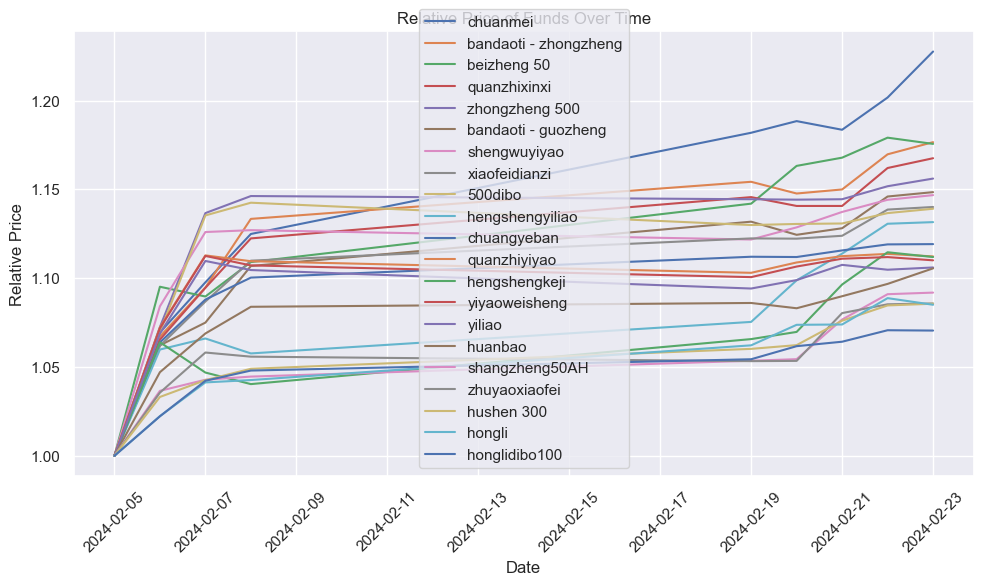

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

# Assuming df contains the relative_price column and date column is already in datetime format
# Get a list of unique stock names

last_date = df_fund_sub['date'].max()
# Filter the DataFrame to get data only for the last date
last_date_data = df_fund_sub[df_fund_sub['date'] == last_date]
# Sort the data by relative_price in descending order
sorted_data = last_date_data.sort_values(by='relative_price', ascending=False)

# Get the sorted list of stock names
sorted_stock_names = sorted_data['name'].tolist()

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate through each stock and plot its relative price over time
for name in sorted_stock_names:
    fund_data = df_fund_sub[df_fund_sub['name'] == name]
    ax.plot(fund_data['date'], fund_data['relative_price'], label=name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Relative Price')
ax.set_title('Relative Price of Funds Over Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

In [49]:
sorted_data

,date,NAV,NAV-Cum,change,code,name,base_NAV,relative_price
143,2024-02-23,0.7303,0.7303,2.15,004753,chuanmei,0.5949,1.227601
54,2024-02-23,1.3919,1.3919,0.59,007301,bandaoti - zhongzheng,1.1830,1.176585
36,2024-02-23,0.9399,0.9399,-0.3,017513,beizheng 50,0.7995,1.175610
63,2024-02-23,0.8690,0.8690,0.47,002974,quanzhixinxi,0.7443,1.167540
9,2024-02-23,0.9636,0.9636,0.38,002903,zhongzheng 500,0.8335,1.156089
45,2024-02-23,0.7458,0.7458,0.21,008888,bandaoti - guozheng,0.6494,1.148445
99,2024-02-23,0.4360,0.4360,0.23,011041,shengwuyiyao,0.3802,1.146765
72,2024-02-23,0.7731,0.7731,0.13,015877,xiaofeidianzi,0.6781,1.140097
179,2024-02-23,1.3046,1.3046,0.22,019359,500dibo,1.1453,1.139090
117,2024-02-23,0.6184,0.6184,0.08,014425,hengshengyiliao,0.5465,1.131565


/var/folders/4r/jygz5t7n24724h42lgmbf1hw0000gn/T/ipykernel_27181/4225696733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fund_sub['date'] = pd.to_datetime(df_fund_sub['date'])


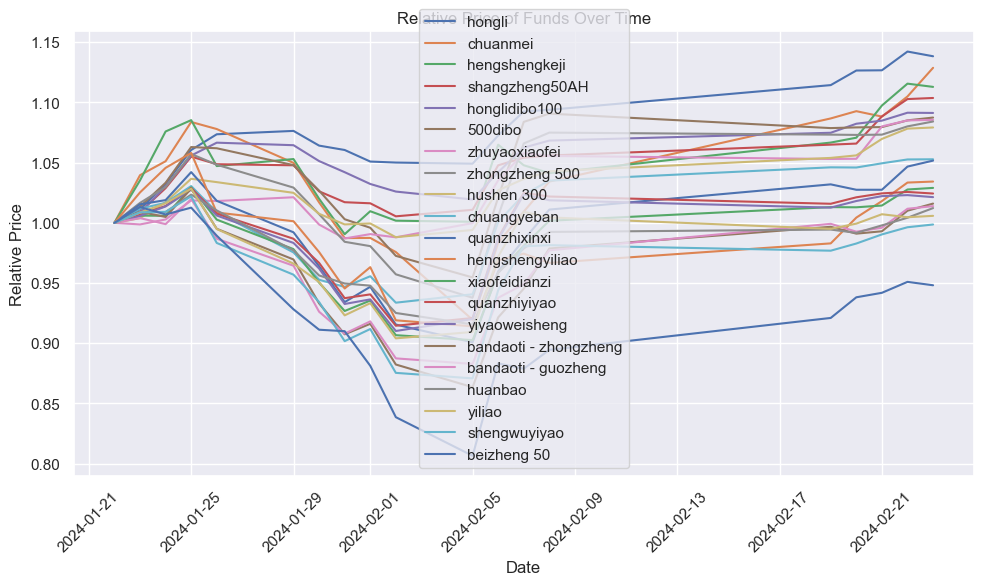

In [50]:
df_fund_sub = df_fund[df_fund['date']>='2024-01-22']
df_fund_sub['date'] = pd.to_datetime(df_fund_sub['date'])
base_nav = df_fund_sub[df_fund_sub['date'] == '2024-01-22'][['name', 'NAV']]

# Rename the 'stock_price' column to 'base_price'
base_nav.columns = ['name', 'base_NAV']

# Merge base_prices with the original DataFrame to get base prices for all dates
df_fund_sub = pd.merge(df_fund_sub, base_nav, on='name', how='left')

# Calculate the relative price ratio
df_fund_sub['relative_price'] = df_fund_sub['NAV'] / df_fund_sub['base_NAV']
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

# Assuming df contains the relative_price column and date column is already in datetime format
# Get a list of unique stock names

last_date = df_fund_sub['date'].max()
# Filter the DataFrame to get data only for the last date
last_date_data = df_fund_sub[df_fund_sub['date'] == last_date]
# Sort the data by relative_price in descending order
sorted_data = last_date_data.sort_values(by='relative_price', ascending=False)

# Get the sorted list of stock names
sorted_stock_names = sorted_data['name'].tolist()

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate through each stock and plot its relative price over time
for name in sorted_stock_names:
    fund_data = df_fund_sub[df_fund_sub['name'] == name]
    ax.plot(fund_data['date'], fund_data['relative_price'], label=name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Relative Price')
ax.set_title('Relative Price of Funds Over Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

In [51]:
sorted_data

,date,NAV,NAV-Cum,change,code,name,base_NAV,relative_price
360,2024-02-23,1.2211,1.3641,-0.34,009052,hongli,1.0727,1.138343
303,2024-02-23,0.7303,0.7303,2.15,004753,chuanmei,0.6470,1.128748
266,2024-02-23,0.4958,0.4958,-0.24,012348,hengshengkeji,0.4455,1.112907
398,2024-02-23,1.2240,1.2240,0.08,501050,shangzheng50AH,1.1090,1.103697
322,2024-02-23,1.1933,1.1933,-0.02,016129,honglidibo100,1.0935,1.091267
379,2024-02-23,1.3046,1.3046,0.22,019359,500dibo,1.1997,1.087439
341,2024-02-23,2.2836,2.2836,0.04,012857,zhuyaoxiaofei,2.1037,1.085516
19,2024-02-23,0.9636,0.9636,0.38,002903,zhongzheng 500,0.8888,1.084158
0,2024-02-23,1.2387,1.2387,0.09,005658,hushen 300,1.1478,1.079195
38,2024-02-23,0.7240,0.7240,0.01,001592,chuangyeban,0.6877,1.052785
